In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors,cm
from scipy import stats
import dispersion_utils as utils
from matplotlib.animation import FuncAnimation
from datetime import timedelta

In [2]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,:,:,:]

In [27]:
min_lat, max_lat = -35, -15
min_lon, max_lon = 5, 20

In [18]:
bins = np.arange(0,106,5)
bin_centers = (bins[1:] + bins[:-1]) / 2
len(bin_centers)

21

In [6]:
def get_sep_array(ds1, ds2, p_total, t_days):
    sep_array_1_2 = np.empty((p_total, t_days))
    sep_array_1_2[:] = np.nan
    for time_step in range(t_days):
        sep_array_1_2[:, time_step] = utils.distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds2['lon'][:, time_step], ds2['lat'][:, time_step])
    return sep_array_1_2

In [14]:
home_folder = "/nethome/manra003/analysis/dispersion/simulations/"
output_folder = "/nethome/manra003/analysis/dispersion/outputs/"

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
threshold_dist = 100    # km-  mesoscale

year = 2017

type1, type2= 'DVM', '3D'
p_total = 58027
t_days=100


In [11]:
all_sep_array = np.empty((p_total, t_days,len(months)))
all_CDFs = np.zeros((len(months),len(bin_centers)))
print("Summary {0}-{1} for all months: {2}".format(type1, type2, year))

#Get monthly CDF from 100 days simulation.
for index, month in enumerate(months):
    # ds1 = xr.open_zarr(home_folder + type1 + "/BenguelaUpwR_1ov16_321x241res_{0}2017_1z_100days_krills.zarr".format(month))
    ds1 = xr.open_zarr(home_folder + type1 + "/BenguelaUpwR_noneres_{0}2017_1z_100days.zarr".format(month))
    
    ds2 = xr.open_zarr(home_folder + type2 + "/BenguelaUpwR_noneres_{0}2017_1z_100days.zarr".format(month))
    
    # ds2 = xr.open_zarr(home_folder + type2 + "/BenguelaUpwR_noneres_{0}2017_1z_100days.zarr".format(month))
    # ds2 = xr.open_zarr(home_folder + type2 + "/BenguelaUpwR_1ov16_321x241res_{0}2017_1z_100days_krills.zarr".format(month))

    # assert files are similar
    assert len(ds1.trajectory) == len(ds2.trajectory)
    assert len(ds1.obs) == len(ds2.obs)

    all_sep_array[:,:,index] = get_sep_array(ds1, ds2, p_total, t_days)
    all_CDFs[index,:],_ = utils.get_diff_CDF_PDF(all_sep_array[:,:,index], threshold_dist, bins)


Summary DVM-3D for all months: 2017
Discarded particles count:  0
Discarded particles count:  0
Discarded particles count:  0
Discarded particles count:  0
Discarded particles count:  1
Discarded particles count:  4
Discarded particles count:  17
Discarded particles count:  11
Discarded particles count:  1
Discarded particles count:  0
Discarded particles count:  0
Discarded particles count:  0


In [12]:
all_sep_array.shape, all_CDFs.shape

np.save(output_folder+"Distances/all_sep_array_{0}_{1}_{2}.npy".format(type1,type2,year), all_sep_array)
np.save(output_folder+"CDF/all_CDF_{0}_{1}_{2}.npy".format(type1,type2,year), all_CDFs)

# np.save(output_folder+"Distances/all_sep_array_copepods{0}_krills{1}_{2}.npy".format(type1,type2,year), all_sep_array)
# np.save(output_folder+"CDF/all_CDF_copepods{0}_krills{1}_{2}.npy".format(type1,type2,year), all_CDFs)

<H3> Load data from previous outputs of previous runs of above cells

In [19]:
# type, type2 = 'DVM', 'DVM' 
if type1==type2 and type1=='DVM':
    all_sep_array = np.load(output_folder+"Distances/all_sep_array_copepods{0}_krills{1}_{2}.npy".format(type1,type2,year))
    all_CDFs = np.load(output_folder+"CDF/all_CDF_copepods{0}_krills{1}_{2}.npy".format(type1,type2,year))
    type1, type2 = 'copepodsDVM', 'krillsDVM' 
else:
    all_sep_array = np.load(output_folder+"Distances/all_sep_array_{0}_{1}_{2}.npy".format(type1,type2,year))
    all_CDFs = np.load(output_folder+"CDF/all_CDF_{0}_{1}_{2}.npy".format(type1,type2,year))


In [20]:
dpi = 300
# color = cm.YlGnBu #
color = cm.magma_r
scatter_size = 1.8

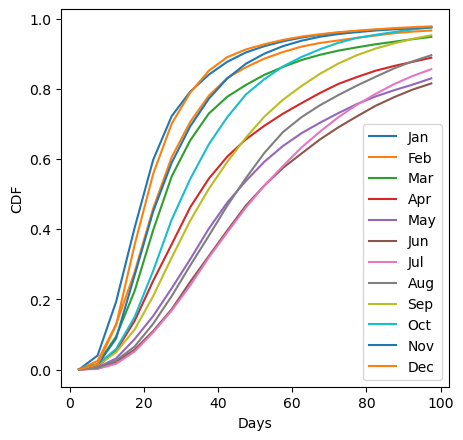

In [21]:
fig = plt.figure(figsize=(5,5), dpi=100)
for index, month in enumerate(months):
    plt.plot(bin_centers[:-1], all_CDFs[index,:-1], label=month)

plt.xlabel("Days")
plt.ylabel("CDF")
plt.legend()

In [22]:
def plot_mean_std(ind,l):
    mean=np.mean(all_CDFs[ind,:],axis=0)
    std=np.nanstd(all_CDFs[ind,:],axis=0)
    plt.plot(bin_centers[:-1], mean[:-1], label=l)
    plt.fill_between(bin_centers[:-1], mean[:-1] - std[:-1], mean[:-1] + std[:-1], alpha=0.2)

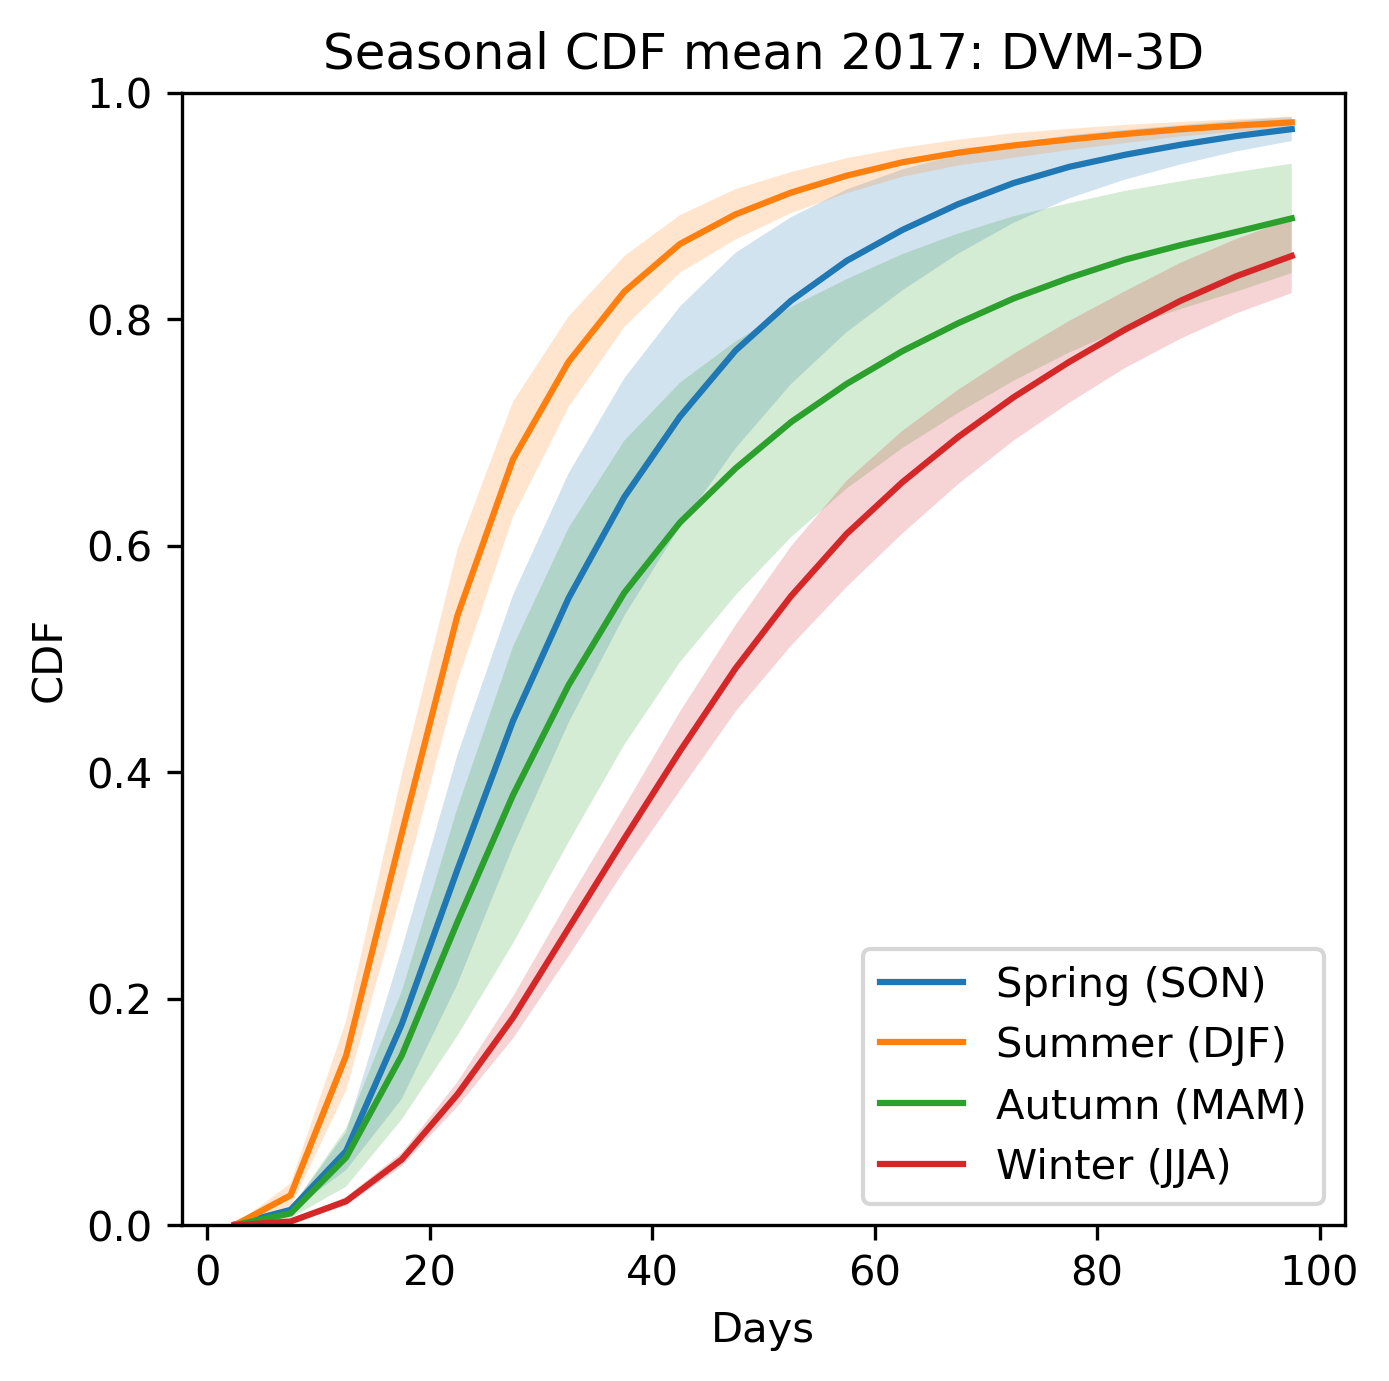

In [23]:
spring_ind = [8,9,10]
summer_ind = [11,0,1]
autumn_ind = [2,3,4]
winter_ind = [5,6,7]
# spring_ind = [3]
# summer_ind = [0]
# autumn_ind = [1]
# winter_ind = [2]

fig = plt.figure(figsize=(5,5), dpi=dpi)
plt.title("Seasonal CDF mean 2017: {0}-{1}".format(type1, type2))
plot_mean_std(spring_ind, "Spring (SON)")
plot_mean_std(summer_ind, "Summer (DJF)")
plot_mean_std(autumn_ind, "Autumn (MAM)")
plot_mean_std(winter_ind, "Winter (JJA)")

plt.xlabel("Days")
plt.ylabel("CDF")
plt.ylim(0,1)
plt.legend()


<h2> Plots of dispersion time for threshold distance

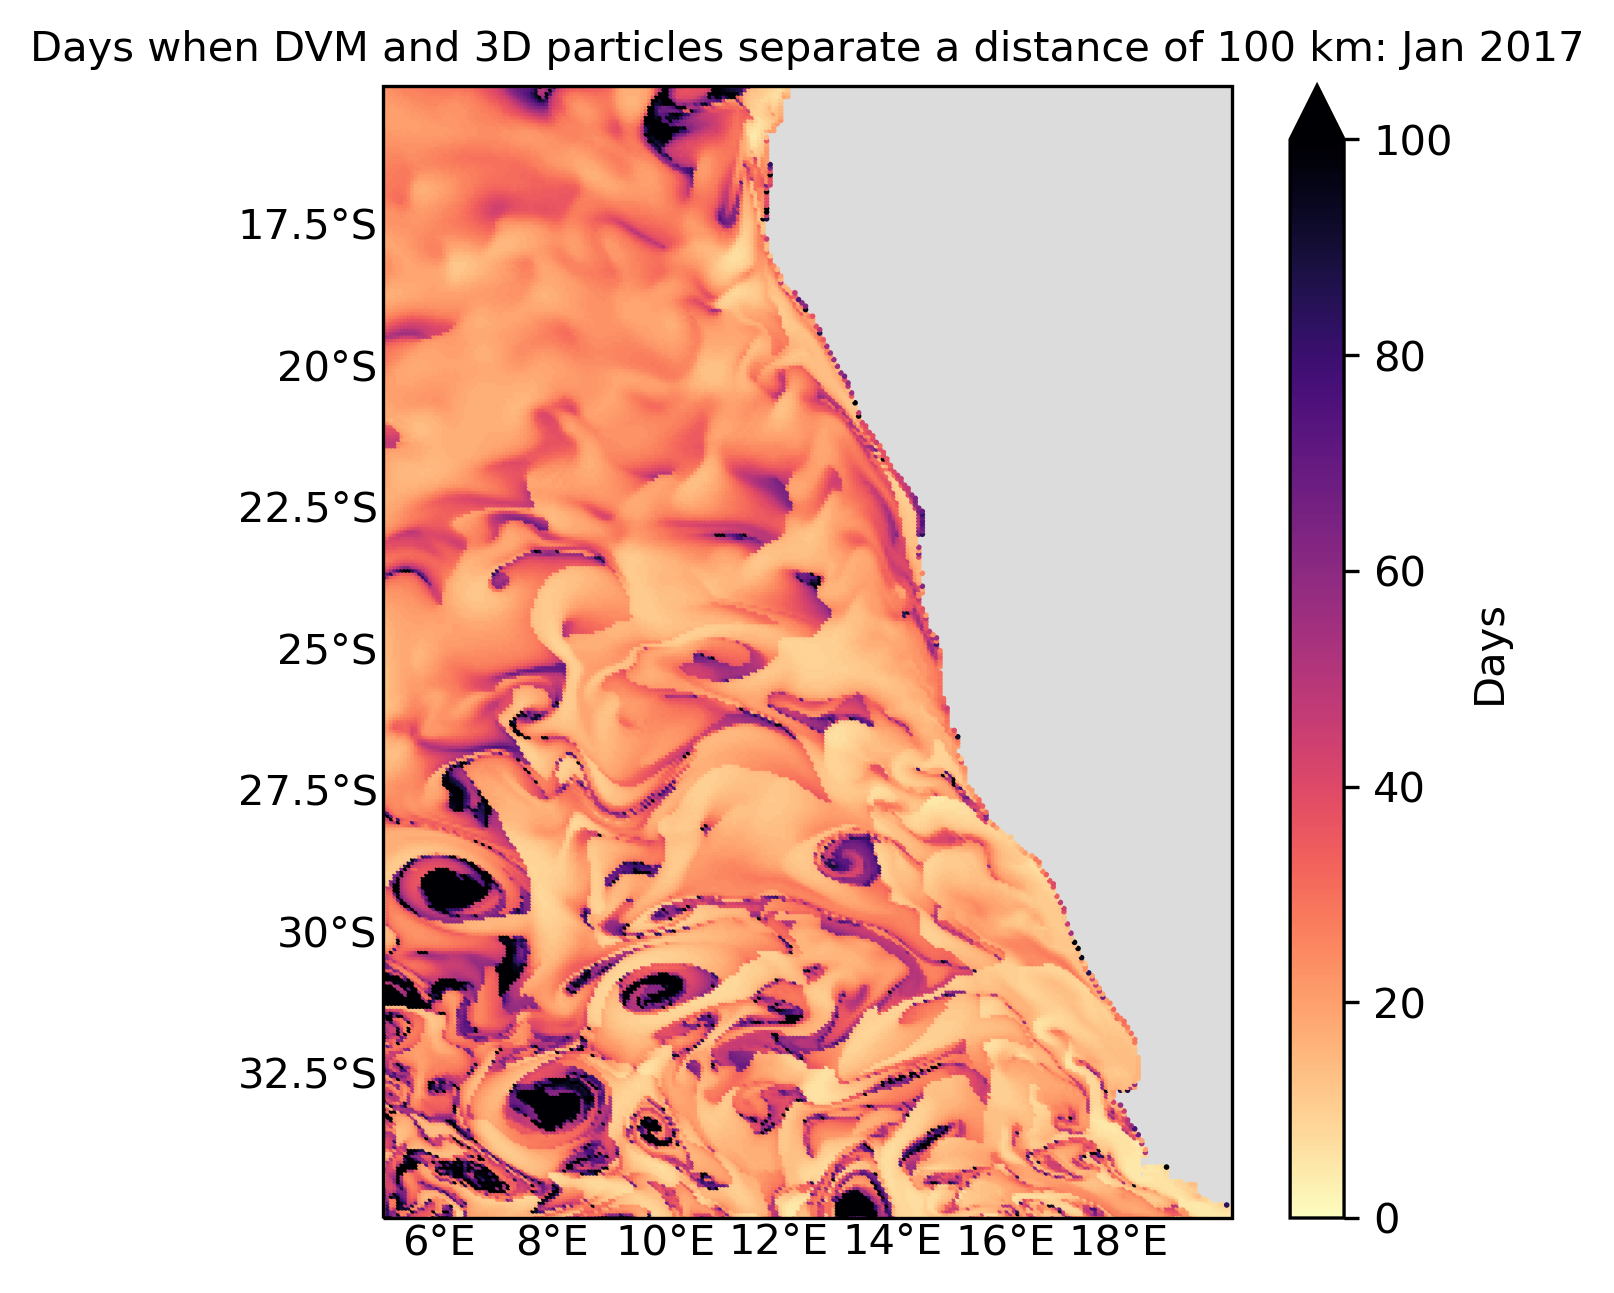

In [28]:
id = 0
ds1 = xr.open_zarr(home_folder + "DVM" + "/BenguelaUpwR_noneres_Jan2017_1z_100days.zarr")

custom_size=10
fig = plt.figure(figsize=(5,5), dpi=dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
plt.title("Days when {0} and {1} particles separate a distance of {2} km: {3} {4}".format(type1, type2, threshold_dist, months[id], year), fontsize=10)

im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= utils.threshold_days(all_sep_array[:,:,id], threshold_dist), s=scatter_size, cmap=color, vmin=0, vmax=100, marker='o',edgecolors='none')
cbar=fig.colorbar(im, ax=ax, label='Days', extend='max')

plt.show()

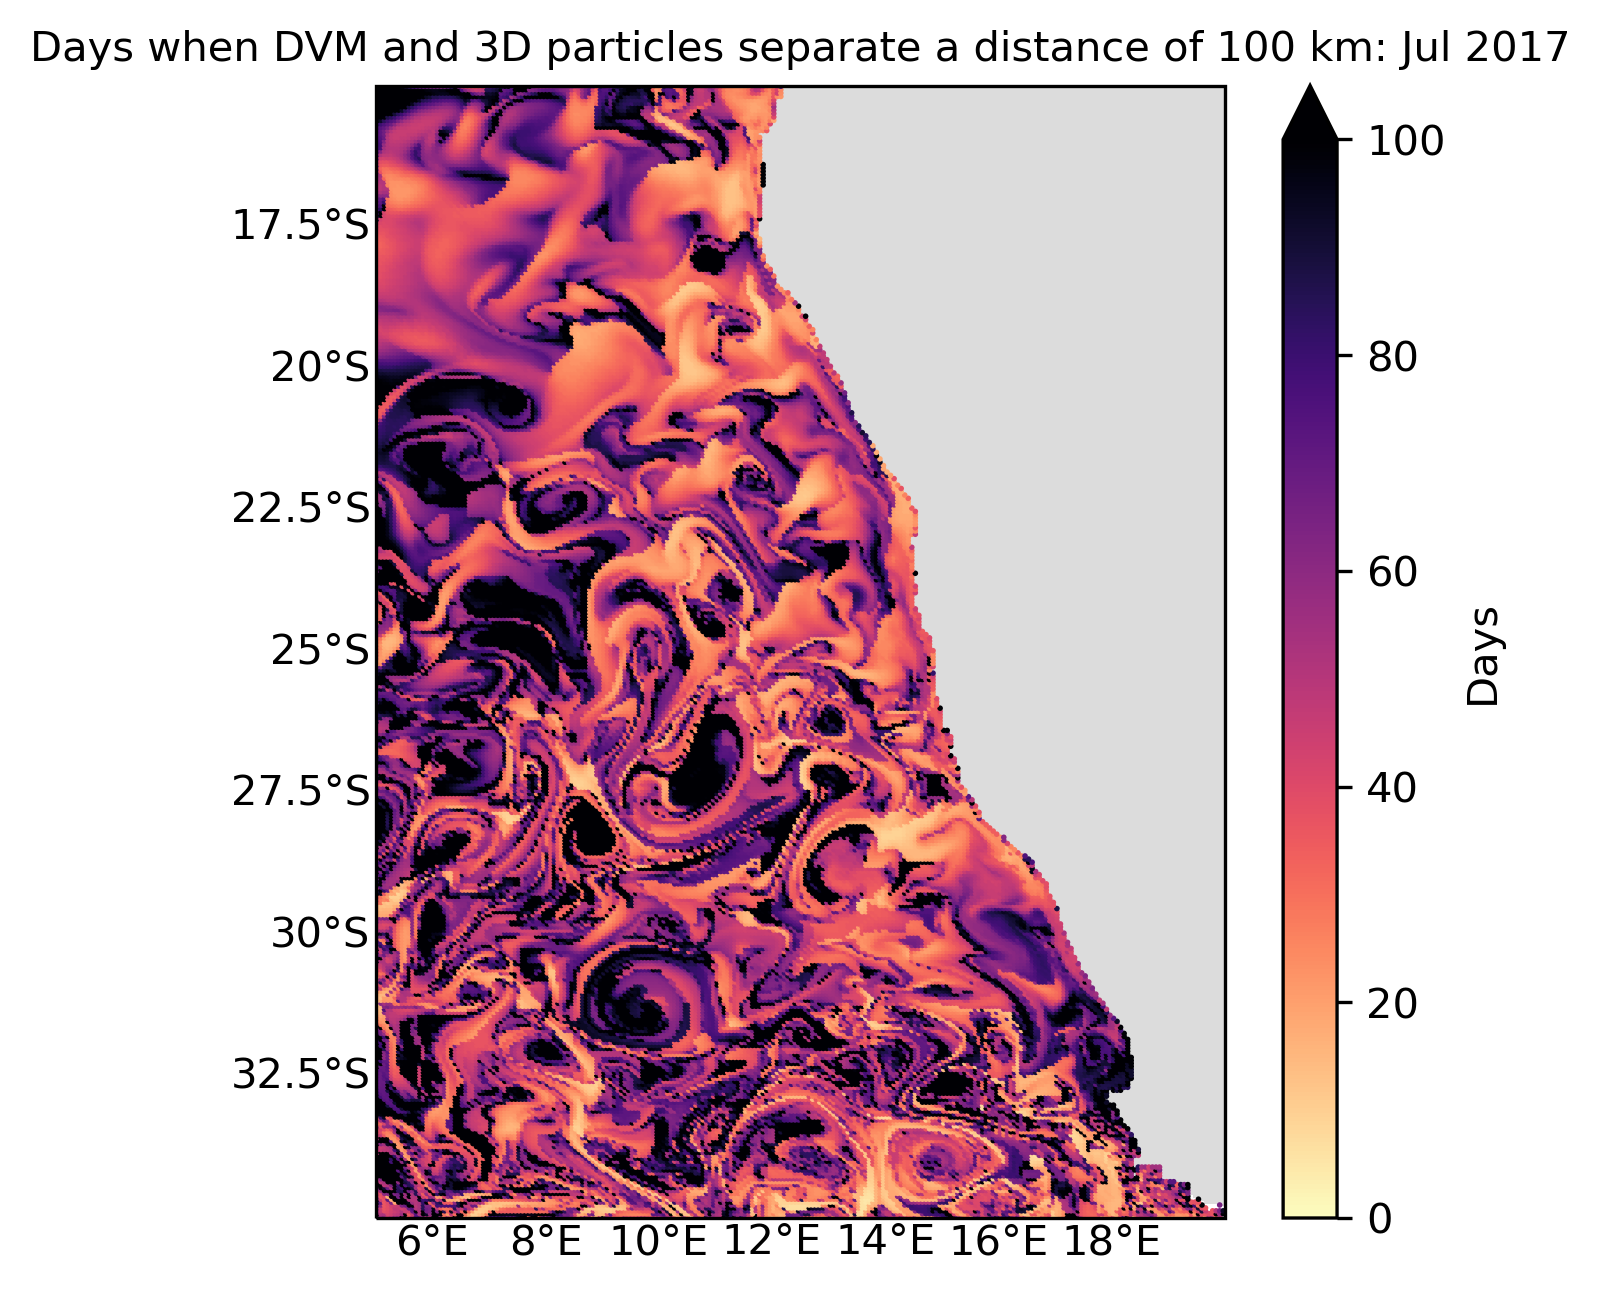

In [29]:
id =6

custom_size=10
fig = plt.figure(figsize=(5,5), dpi=dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
plt.title("Days when {0} and {1} particles separate a distance of {2} km: {3} {4}".format(type1, type2, threshold_dist, months[id], year), fontsize=10)
# plt.title("Lateral separation of {0} km in {1} {2}: {3} & {4} ".format(threshold_dist, months[id], year, type1, type2))

im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= utils.threshold_days(all_sep_array[:,:,id], threshold_dist),  s=scatter_size, cmap=color, vmin=0, vmax=100, marker='o',edgecolors='none')
cbar=fig.colorbar(im, ax=ax, label='Days', extend='max')

plt.show()

In [30]:
print(np.where(np.isnan(utils.threshold_days(all_sep_array[:,:,id],threshold_dist))))
raise KeyError

(array([ 239,  347,  715,  955,  956,  957,  958,  959, 1067, 1194, 1195,
       1196, 1197, 1432, 1663, 1664, 1896]),)


KeyError: 

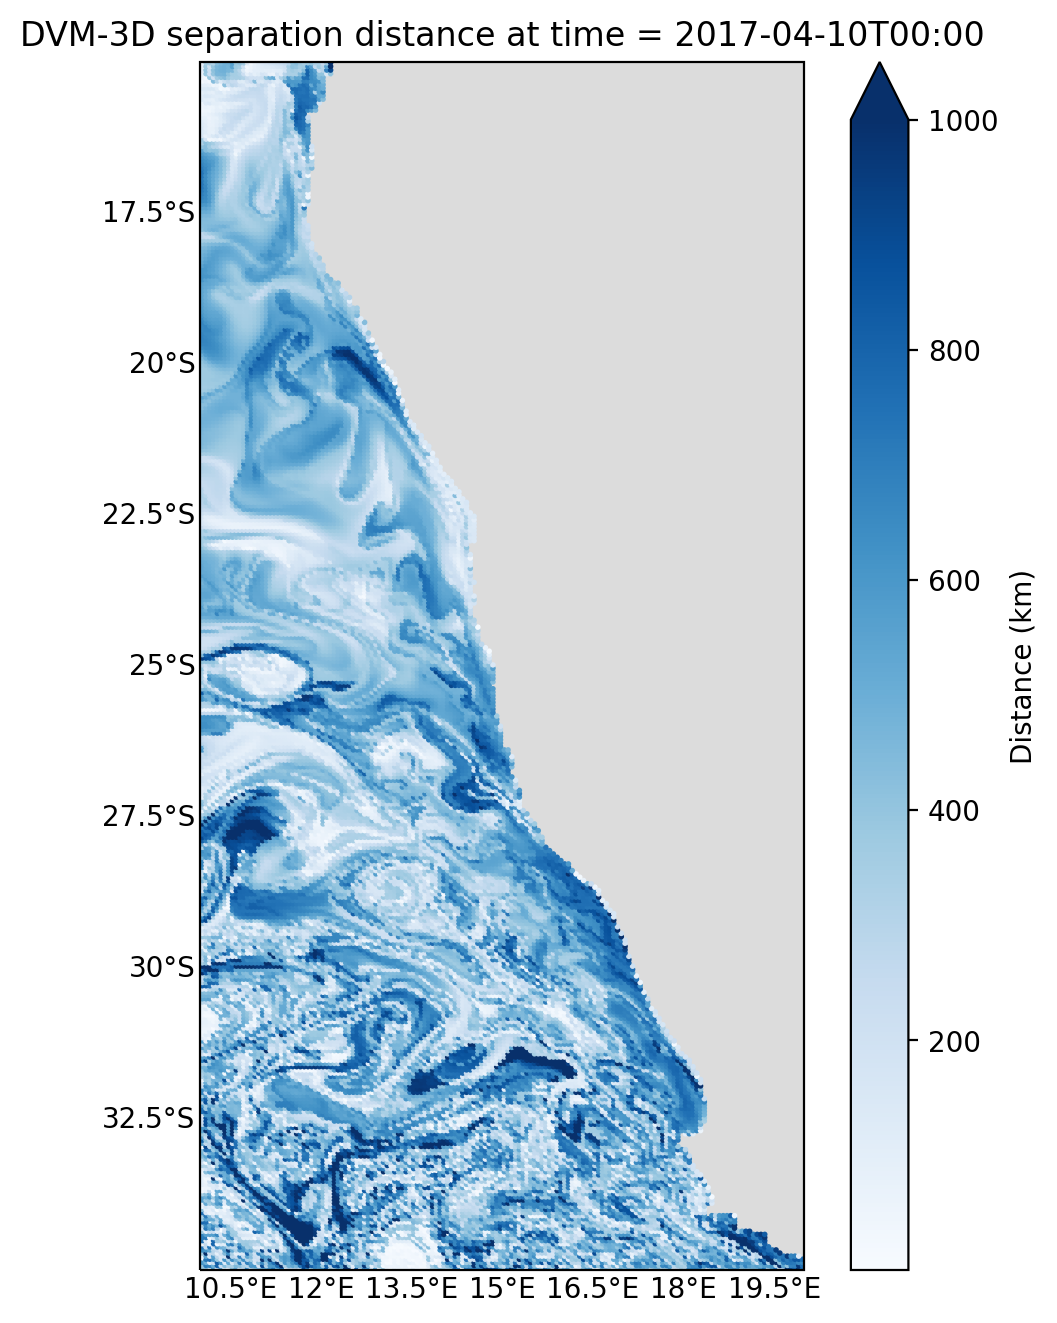

In [ ]:
# 1: 2D, 2: 3D, 3: DVM, 4: BP 
i=0 #Jan
input_array = all_sep_array[:,:,i]

pre_text='{0}-{1} separation distance at time = '.format(type1, type2)

custom_size=10
fig = plt.figure(figsize=(6,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
output_dt = timedelta(days=1)
time_range = np.arange(np.nanmin(ds1['time'].values),
                       np.nanmax(ds1['time'].values) + np.timedelta64(output_dt),
                       output_dt) 
color=cm.Blues
norm = colors.Normalize(vmin=0.0001, vmax=1000)
scatter=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= input_array[:,0], s=1, cmap=color,norm=norm, marker='o',edgecolors='none')
cbar=fig.colorbar(scatter, ax=ax, label='Distance (km)', extend='max')
t = np.datetime_as_string(time_range[0], unit='m')
title = ax.set_title(pre_text + t)

def animate(i):
    t = np.datetime_as_string(time_range[i], unit='m')
    title.set_text(pre_text + t)
    scatter.set_color(color(norm(input_array[:,i])))
    

size = t_days
anim = FuncAnimation(fig, animate, frames=size, interval=200)
anim.save(output_folder + 'animations/sep_distances_time_{0}_{1}_Jan_2017.mp4'.format(type1,type2))

# takes 13 mins for highest resolution


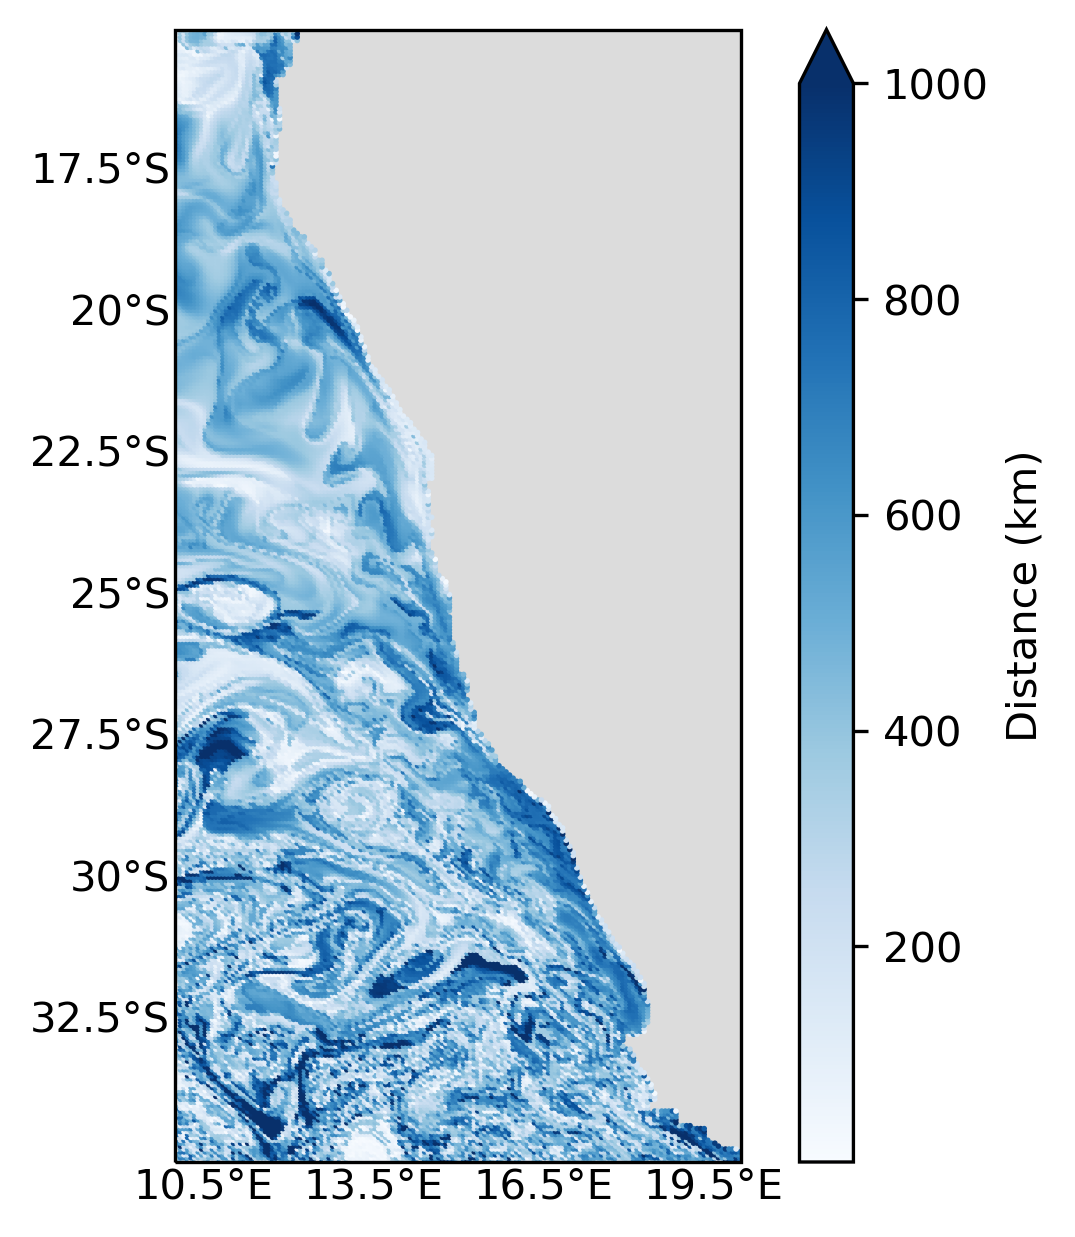

In [ ]:
i=0 #Jan
input_array = all_sep_array[:,:,i]

pre_text='{0}-{1} separation distance at time = '.format(type1, type2)

custom_size=10
fig = plt.figure(figsize=(5,5), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

output_dt = timedelta(days=1)
time_range = np.arange(np.nanmin(ds1['time'].values),
                       np.nanmax(ds1['time'].values) + np.timedelta64(output_dt),
                       output_dt) 

norm = colors.Normalize(vmin=0.0001, vmax=1000)
scatter=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= input_array[:,-1], s=scatter_size, cmap=cm.Blues, marker='o',edgecolors='none',vmin=0.0001, vmax=1000)
cbar=fig.colorbar(scatter, ax=ax, label='Distance (km)', extend='max')

In [ ]:
diff= np.random.uniform(0,100,50)
print(stats.describe(diff, axis= None, nan_policy='omit'))
count, _ = np.histogram(diff, bins=bins)

pdf = count/np.sum(count)

cdf = np.cumsum(pdf)
count,len(count), np.sum(count), cdf

DescribeResult(nobs=50, minmax=(0.44245729351130025, 99.26102823167663), mean=48.751026186341875, variance=1321.8708322705897, skewness=0.12255995095740319, kurtosis=-1.5861476052453445)


(array([8, 2, 2, 4, 1, 2, 4, 2, 2, 2, 0, 0, 0, 1, 1, 1, 6, 2, 3, 7, 0]),
 21,
 50,
 array([0.16, 0.2 , 0.24, 0.32, 0.34, 0.38, 0.46, 0.5 , 0.54, 0.58, 0.58,
        0.58, 0.58, 0.6 , 0.62, 0.64, 0.76, 0.8 , 0.86, 1.  , 1.  ]))

In [ ]:

print(stats.describe(diff, axis= None, nan_policy='omit'))
count, _ = np.histogram(diff, bins=bins)
pdf = count/len(diff)
cdf = np.cumsum(pdf)
count,len(count), np.sum(count), cdf

DescribeResult(nobs=50, minmax=(0.44245729351130025, 99.26102823167663), mean=48.751026186341875, variance=1321.8708322705897, skewness=0.12255995095740319, kurtosis=-1.5861476052453445)


(array([8, 2, 2, 4, 1, 2, 4, 2, 2, 2, 0, 0, 0, 1, 1, 1, 6, 2, 3, 7, 0]),
 21,
 50,
 array([0.16, 0.2 , 0.24, 0.32, 0.34, 0.38, 0.46, 0.5 , 0.54, 0.58, 0.58,
        0.58, 0.58, 0.6 , 0.62, 0.64, 0.76, 0.8 , 0.86, 1.  , 1.  ]))

In [ ]:

diff[20:30]=-100
print(stats.describe(diff, axis= None, nan_policy='omit'))
count, _ = np.histogram(diff, bins=bins)

pdf = count/len(diff)
cdf = np.cumsum(pdf)
count,len(count), np.sum(count), cdf

DescribeResult(nobs=50, minmax=(-100.0, 99.26102823167663), mean=17.31998875055717, variance=4575.760913363393, skewness=-0.6760176254546071, kurtosis=-0.6761137794884906)


(array([7, 2, 1, 4, 1, 1, 4, 2, 1, 1, 0, 0, 0, 1, 0, 1, 5, 2, 2, 5, 0]),
 21,
 40,
 array([0.14, 0.18, 0.2 , 0.28, 0.3 , 0.32, 0.4 , 0.44, 0.46, 0.48, 0.48,
        0.48, 0.48, 0.5 , 0.5 , 0.52, 0.62, 0.66, 0.7 , 0.8 , 0.8 ]))

In [ ]:
np.min(ds1.lon[:,0].values)

5.03125